# mnist

In [2]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [4]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/multiclass/mnist_scale(60000,780).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/multiclass/mnist_scale_test(10000,780).txt')
data_name = 'mnist'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

y_tr = (y_tr %2 == 0).astype(float)
y_test = (y_test %2 == 0).astype(float)

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape
print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 10000
of features: 778
mnist


## K-Means cluster centers

In [5]:
ind_num = 1000
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [6]:
with open('../plots/vi_vs_svi_class/'+ data_name +'_title.txt', 'w') as f:
    title = data_name + ' dataset, ' + 'n = ' + str(num) + ', d = ' + str(dim) + ', m = ' + str(ind_num)
    f.write(title)

In [7]:
cov_params = np.array([150., 200., 0.01])

## svi-L-BFGS-B-c method

In [20]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [21]:
opts = {'mode': 'full', 'maxiter': 200, 'mydisp': False}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [22]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=10)

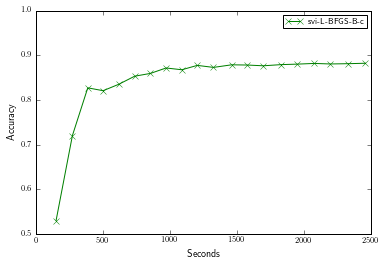

In [23]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.5, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method
Подбор числа пересчетов

In [7]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'maxfun':maxfun, 'mydisp': True, 'num_updates':5}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=7))
    print()

5
Hyper-parameters at iteration 0 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.05351242e+02   2.34522356e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  5.60827986e+01   2.49729979e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  4.41149114e+01   2.51814080e+02   1.00000000e-02]
Hyper-parameters at iteration 4 : [  4.28073715e+01   2.52036751e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  4.31851341e+01   2.51976494e+02   1.00000000e-02]
Hyper-parameters at iteration 0 : [  4.31851341e+01   2.51976494e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  3.58137817e+01   2.53257999e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  3.50587493e+01   2.53388500e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  3.52453436e+01   2.53356848e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  3.52453436e+01   2.53356848e+02   1.00000000e-02]
Hyper-parameters at itera

0
1
2
3


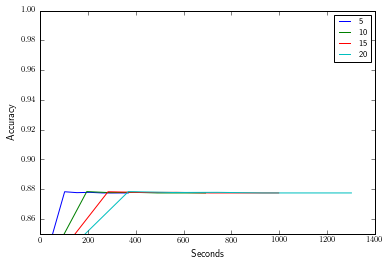

In [8]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    vi_x_lst, vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(vi_x_lst[1:], vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([0.85, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Обучим лучшую модель

In [34]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=5)

Hyper-parameters at iteration 0 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.27704108e+02   2.19102963e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  7.13722816e+01   2.50319126e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  5.39990063e+01   2.58146480e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  4.61744130e+01   2.61622445e+02   1.00000000e-02]
Hyper-parameters at iteration 0 : [  4.61744130e+01   2.61622445e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  4.26221729e+01   2.62328138e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  3.81469554e+01   2.63252238e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  3.93960833e+01   2.63004472e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  3.93959293e+01   2.63004504e+02   1.00000000e-02]
Hyper-parameters at iteration 0 : [  3.93959293e+01   2.63004504e+02   1.00000000e-02]
Hyper-parameters at iterati

In [35]:
predicted = vi_gp.predict(x_test)
print(accuracy_score(y_test, predicted))

0.8968


In [36]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

KeyboardInterrupt: 

### Stochastic Taylor

In [24]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'mode': 'adadelta', 'num_updates': 2, 'mydisp': True, 'print_freq': 1, 'step_rate': 5.,
        'maxiter': 1, 'batch_size':5000}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=10)

Iteration  1 :
	Gradient norm 1400.79359371
	Hyper-parameters at outter iteration 0 : [ 147.23896239  202.65229797   -2.57340278]
Iteration  1 :
	Gradient norm 1651.10197892
	Hyper-parameters at outter iteration 1 : [  1.44720370e+02   2.05165457e+02  -1.44034351e-01]
Iteration  1 :
	Gradient norm 139.927314296
	Hyper-parameters at outter iteration 2 : [ 142.16970662  207.7214926     0.5086339 ]
Iteration  1 :
	Gradient norm 1036.21068559
	Hyper-parameters at outter iteration 3 : [  1.39716295e+02   2.10160808e+02  -1.93664360e-02]
Iteration  1 :
	Gradient norm 771.582376932
	Hyper-parameters at outter iteration 4 : [ 136.81937174  212.99893001    2.7306231 ]
Iteration  1 :
	Gradient norm 1352.74787073
	Hyper-parameters at outter iteration 5 : [ 134.286629    215.52421649    0.41666768]
Iteration  1 :
	Gradient norm 539.250790066
	Hyper-parameters at outter iteration 6 : [ 131.81485716  217.94267918   -0.93412001]
Iteration  1 :
	Gradient norm 833.986249591
	Hyper-parameters at outter 

In [25]:
predicted = vi_gp.predict(x_test)
print(accuracy_score(y_test, predicted))

0.8789


In [26]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_st_x_lst, vi_st_y_lst = vi_res.plot_performance(metric, 't', freq=2)
plt.plot(vi_st_x_lst[1:], vi_st_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

KeyboardInterrupt: 

###JJ-full

In [8]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'maxiter':5, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02   1.00000000e+00
   1.00000000e+00]
Hyper-parameters at iteration 1 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02   1.00000000e+00
   1.00000000e+00]
Hyper-parameters at iteration 2 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02   1.00000000e+00
   1.00000000e+00]
Hyper-parameters at iteration 3 : [  1.39245587e+02   2.11778847e+02   1.00000000e-02   1.04900430e+00
   1.00564397e+00]
Hyper-parameters at iteration 4 : [  9.28786869e+01   2.61237494e+02   1.00000000e-02   1.28350757e+00
   1.02932750e+00]
Hyper-parameters at iteration 5 : [  4.40513014e+01   3.35514430e+02   2.78592014e-01   1.63497336e+00
   1.06489588e+00]
Hyper-parameters at iteration 6 : [  4.32766397e+01   3.40309438e+02   2.88792766e-01   1.65768380e+00
   1.06719205e+00]


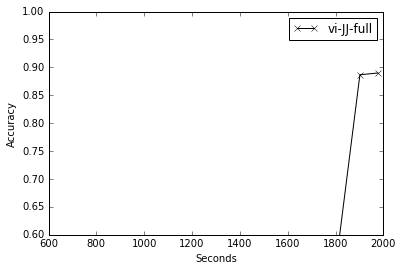

In [9]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_full_x_lst, vi_full_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [16]:
results = []
steps = [2., 1., 0.5]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 200, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)
    print()

2.0
Iteration  1 :
	Gradient norm 53.712642351
Iteration  2 :
	Gradient norm 86.4073433096
Iteration  3 :
	Gradient norm 2.36768271218
Iteration  4 :
	Gradient norm 1450.95951487
Iteration  5 :
	Gradient norm 4700.22346342
Iteration  6 :
	Gradient norm 770218.449211
Iteration  7 :
	Gradient norm 231029.091963
Iteration  8 :
	Gradient norm 5844451.24756
Iteration  9 :
	Gradient norm 3038123.06656
Iteration  10 :
	Gradient norm 261043539.855
Iteration  11 :
	Gradient norm 443746102332.0
Iteration  12 :
	Gradient norm 209895.092425
Iteration  13 :
	Gradient norm 29512.0559879
Iteration  14 :
	Gradient norm 2327.15290713
Iteration  15 :
	Gradient norm 1856.39512447
Iteration  16 :
	Gradient norm 0.422806480367
Iteration  17 :
	Gradient norm 0.0356820463438
Iteration  18 :
	Gradient norm 0.0348937620693
Iteration  19 :
	Gradient norm 0.0341579175643
Iteration  20 :
	Gradient norm 0.0334687855855

1.0
Iteration  1 :
	Gradient norm 23.837929832
Iteration  2 :
	Gradient norm 23.4881293373
Iter

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2


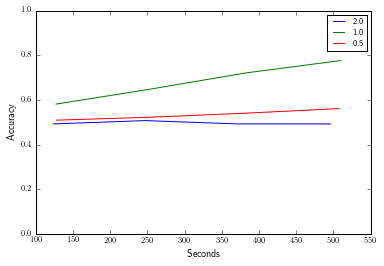

In [17]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=5)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [ ]:
results = []
steps = [2., 1., 0.5]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 100, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)
    predicted = ad_gp.predict(x_test)
    print(accuracy_score(y_test, predicted))
    print()

2.0
Iteration 

In [ ]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):

#     svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=10)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [25]:
results = []
steps = [5., 2., 1.]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 500, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)
    predicted = ad_gp.predict(x_test)
    print(accuracy_score(y_test, predicted))
    print()

5.0
Iteration  1 :
	Gradient norm 14.9745959297
Iteration  2 :
	Gradient norm 20174.6513172
Iteration  3 :
	Gradient norm 62819.1097698
Iteration  4 :
	Gradient norm 343569682.05
Iteration  5 :
	Gradient norm 2719981.3237
Iteration  6 :
	Gradient norm 83311508.6561
Iteration  7 :
	Gradient norm 154501831.991
Iteration  8 :
	Gradient norm 16340225.8385
Iteration  9 :
	Gradient norm 486098668.077
Iteration  10 :
	Gradient norm 4.64540164402e+12
Iteration  11 :
	Gradient norm 2.93476280172e+12
Iteration  12 :
	Gradient norm 8.84306072675e+13
Iteration  13 :
	Gradient norm 4.86817428757e+12
Iteration  14 :
	Gradient norm 4.25543838493e+16
Iteration  15 :
	Gradient norm 9.54978227262e+16
Iteration  16 :
	Gradient norm 2.10113289997e+21
Iteration  17 :
	Gradient norm 1.40798499421e+23
Iteration  18 :
	Gradient norm 3.39929204414e+19
Iteration  19 :
	Gradient norm 4.00636702066e+23
Iteration  20 :
	Gradient norm 2.97349710677e+26
0.5074

2.0
Iteration  1 :
	Gradient norm 60.9219527432
Iterati

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


In [ ]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=5)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [27]:
results = []
steps = [10., 5., 2., 1.]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 1000, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)
    predicted = ad_gp.predict(x_test)
    print(accuracy_score(y_test, predicted))
    print()

10.0
Iteration  1 :
	Gradient norm 102.258994639
Iteration  2 :
	Gradient norm 1462.41594166
Iteration  3 :
	Gradient norm 27391393.4927
Iteration  4 :
	Gradient norm 158346278.576
Iteration  5 :
	Gradient norm 99638289.946
Iteration  6 :
	Gradient norm 26310414.4965
Iteration  7 :
	Gradient norm 1675540.11491
Iteration  8 :
	Gradient norm 366035104.648
Iteration  9 :
	Gradient norm 17090309.823
Iteration  10 :
	Gradient norm 243969177.064
Iteration  11 :
	Gradient norm 1078421268.17
Iteration  12 :
	Gradient norm 1288662452.21
Iteration  13 :
	Gradient norm 995602557.464
Iteration  14 :
	Gradient norm 1106575391.99
Iteration  15 :
	Gradient norm 3935810248.24
Iteration  16 :
	Gradient norm 6153248227.85
Iteration  17 :
	Gradient norm 1217123332.38
Iteration  18 :
	Gradient norm 8639381003.43
Iteration  19 :
	Gradient norm 2015055749.59
Iteration  20 :
	Gradient norm 9001875262.91
0.5074

5.0
Iteration  1 :
	Gradient norm 1593.40259756
Iteration  2 :
	Gradient norm 245.060107415
Iterat

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N
/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:600: RuntimeWarning: invalid value encountered in sqrt
  S_i = np.sqrt((K_ii + np.einsum('ij,ji->i', k_i.T, K_mm_inv.dot((sigma - K_mm).dot(K_mm_inv.dot(k_i))))).T)


 17 :
	Gradient norm 97.6413320908
[[ nan]
 [ nan]
 [ nan]]


NameError: name 'exit' is not defined

In [ ]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=5)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [30]:
results = []
steps = [0.5]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 5000, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)
    predicted = ad_gp.predict(x_test)
    print(accuracy_score(y_test, predicted))
    print()

0.5
Iteration  1 :
	Gradient norm 893.784466238
Iteration  2 :
	Gradient norm 1209.94730007
Iteration  3 :
	Gradient norm 1335.7733194
Iteration  4 :
	Gradient norm 1346.17755284
Iteration  5 :
	Gradient norm 1281.35235621
Iteration  6 :
	Gradient norm 1187.24647676
Iteration  7 :
	Gradient norm 1083.17604151
Iteration  8 :
	Gradient norm 978.963466123
Iteration  9 :
	Gradient norm 879.27108324
Iteration  10 :
	Gradient norm 796.782180842
Iteration  11 :
	Gradient norm 702.855560978
Iteration  12 :
	Gradient norm 624.205389258
Iteration  13 :
	Gradient norm 553.412923403
Iteration  14 :
	Gradient norm 502.855516211
Iteration  15 :
	Gradient norm 445.614996186
Iteration  16 :
	Gradient norm 397.854008576
Iteration  17 :
	Gradient norm 353.978145295
Iteration  18 :
	Gradient norm 325.190007063
Iteration  19 :
	Gradient norm 306.735171595
Iteration  20 :
	Gradient norm 291.417230984
0.5371



In [ ]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=5)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [ ]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 100, 'verbose': True, 'batch_size': 200, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [ ]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=10)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

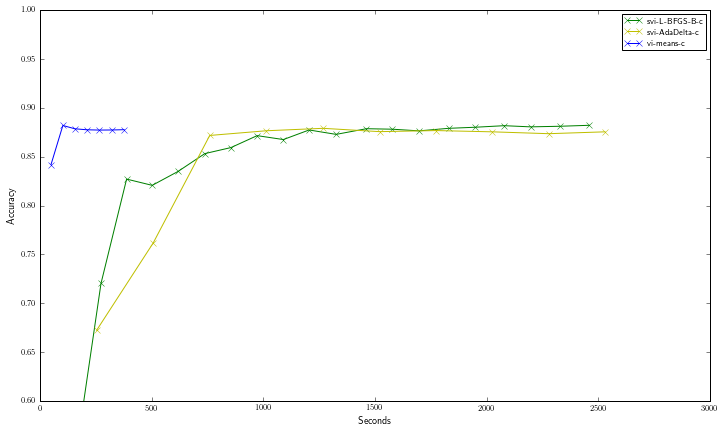

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [13]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)